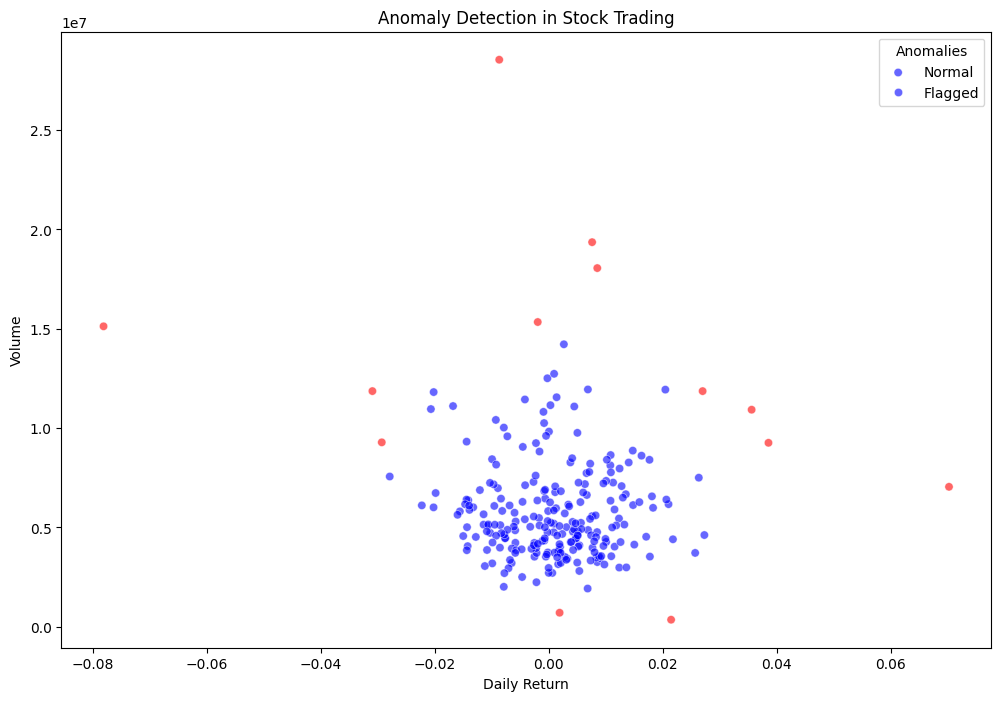

In [2]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
stock_data = pd.read_csv(r"C:\Users\vaibh\Downloads\stock_data.csv")

# Preprocessing
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%m/%d/%Y')
stock_data['VOLUME'] = pd.to_numeric(stock_data['VOLUME'], errors='coerce')

# Sort data by 'Date' for consistency
stock_data.sort_values(by=['symbol_name', 'Date'], inplace=True)

# Calculate daily returns and 10-day moving averages
stock_data['Daily_Return'] = stock_data.groupby('symbol_name')['PREV_CLOSE'].pct_change()
stock_data['Moving_Avg_10'] = stock_data.groupby('symbol_name')['PREV_CLOSE'].transform(lambda x: x.rolling(window=10).mean())

# Prepare features for anomaly detection
aml_features = stock_data[['VOLUME', 'Daily_Return']].dropna()

# Train Isolation Forest for anomaly detection
model = IsolationForest(contamination=0.05, random_state=42)
aml_features['Anomaly_Score'] = model.fit_predict(aml_features)

# Merge anomaly scores back into the main dataset
stock_data = stock_data.join(aml_features['Anomaly_Score'])

# Flag anomalies (Anomaly_Score = -1)
stock_data['Flagged'] = stock_data['Anomaly_Score'] == -1

# Save flagged transactions to a CSV file
flagged_transactions = stock_data[stock_data['Flagged']]
flagged_transactions.to_csv("flagged_transactions.csv", index=False)

# Visualization: Scatter plot of Volume vs Daily_Return highlighting anomalies
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=aml_features,
    x='Daily_Return',
    y='VOLUME',
    hue=aml_features['Anomaly_Score'] == -1,
    palette={True: 'red', False: 'blue'},
    alpha=0.6
)
plt.title("Anomaly Detection in Stock Trading")
plt.xlabel("Daily Return")
plt.ylabel("Volume")
plt.legend(title="Anomalies", labels=["Normal", "Flagged"])
plt.show()
